# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. <br>
## Вариант 15 <br>
## ПМИ3-1, Лязер Г.В.

| Номер варианта | Данные | Зависимая перемменная | Объясняющие переменные | Метод снижения размерности | Метод регуляризации |
|:--------------:|:------|:---------------------:|:----------------------|:--------------------------:|:-------------------:|
| 15             | defoult_of_credit <br> card_clients | -Y | все, кроме: Y, PAY_4, PAY_5, PAY_6, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT4, PAY_AMT5, PAY_AMT6 | PCR | ридж-регрессия |

In [117]:
import numpy as np

import pandas as pd

from scipy.stats import t

from collections import Counter

import matplotlib as mpl

import seaborn as sns

from sklearn import datasets

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import accuracy_score, classification_report

In [118]:
my_seed = 15

plt = mpl.pyplot

mpl.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")


In [119]:
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3.):
	fig = plt.figure()
	ax = plt.subplot(111)

	colors = sns.color_palette("Spectral", len(col_names)-1)

	weights, params = [], []
	for c in np.arange(C_min_pow, C_max_pow+1):
		lr = LogisticRegression(penalty=penalty_name, C=10.**c, solver='liblinear', multi_class='ovr', random_state=my_seed)
		lr.fit(X, y)
		weights.append(lr.coef_[class_number])
		params.append(10**c)
	
	weights = np.array(weights)

	for column, color in zip(range(weights.shape[1]), colors):
		plt.plot(params, weights[:, column], label=col_names[column], color=color)

	plt.axvline(x=C_opt[class_number], color='red', linestyle='--', linewidth=1)
	plt.axhline(0, color='black', linestyle='--', linewidth=1)
	plt.xlim([10**C_min_pow, 10**C_max_pow])
	plt.ylabel('weight coefficient')
	plt.xlabel('C')
	plt.xscale('log')
	plt.legend(loc='upper left')
	ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
	plt.show()

In [120]:
DF_all = pd.read_csv('https://raw.githubusercontent.com/aksyuk/MTML/refs/heads/main/Labs/data/default_of_credit_card_clients.csv')

DF_all = DF_all.drop(['PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis=1)

print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 15)


In [121]:
DF = DF_all.sample(frac=0.85, random_state=my_seed)

DF_predict = DF_all.drop(DF.index)

In [122]:
DF.iloc[:, :7].head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2
1301,10000,2,3,2,22,0,0
26985,360000,1,1,1,32,-1,-1
7182,60000,2,2,1,30,2,0
1906,360000,2,2,1,42,-1,-1
27856,70000,2,2,2,22,0,0


In [123]:
DF.iloc[:, 7:].head()

,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,PAY_AMT1,PAY_AMT2,PAY_AMT3,Y
1301,2,10012,9784,9473,2452,7,308,1
26985,-2,2500,0,0,0,0,0,0
7182,0,60558,59361,60167,3500,3000,1000,1
1906,-1,22237,5683,1632,6695,1632,1632,0
27856,0,66748,52642,40934,2049,1700,1446,0


In [124]:
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
Y            int64
dtype: object

In [125]:
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
Y            0
dtype: int64

In [126]:
for var in DF.columns: 
	print(var, 'unique:\n', DF[var].unique(), '\n\n')

LIMIT_BAL unique:
 [ 10000 360000  60000  70000 210000  20000 120000 180000  80000 200000
  50000 150000  30000 300000 240000 290000 340000 100000 160000 230000
  90000 320000 170000 190000 140000 260000 400000 330000 450000 370000
 390000 500000 380000  40000 270000 130000 420000 480000 110000 550000
 430000 250000 350000 490000 280000 220000 310000 600000 440000 710000
 410000 560000 620000 510000 460000 520000 580000 470000 590000 630000
 530000 570000 650000 680000 750000 700000 610000 640000 540000 740000
 660000 720000 670000  16000 730000 800000 780000] 


SEX unique:
 [2 1] 


EDUCATION unique:
 [3 1 2 6 5 4 0] 


MARRIAGE unique:
 [2 1 3 0] 


AGE unique:
 [22 32 30 42 36 47 23 28 45 33 43 46 34 38 35 24 27 55 29 37 41 49 25 39
 44 40 26 52 58 51 57 48 54 31 50 63 62 56 59 60 53 67 65 21 69 70 64 61
 66 68 79 73 75 71 72 74] 


PAY_0 unique:
 [ 0 -1  2 -2  1  3  5  6  4  8  7] 


PAY_2 unique:
 [ 0 -1 -2  2  3  4  5  1  7  6  8] 


PAY_3 unique:
 [ 2 -2  0 -1  3  7  4  5  6  1

### Предварительный анализ данных
#### Описательная статистика
Считаем доли классов целевой переменной `Y`

In [127]:
DF.Y.unique()

array([1, 0])

In [128]:
np.around(DF.Y.value_counts() / len(DF.index), 3)

Y
0    0.779
1    0.221
Name: count, dtype: float64

Всего целевых классов 2, их доли разнятся. Доля класса `0` сузественно превышет долю класса `1`. Среди переменных непрерывных нет. Как количественные можно трактовать переменные `LIMIT_BAL`, `BILL_AMT(1-3)` и `PAY_AMT(1-3)`, а также `AGE`. Расчитаем для них описательные статистики.

In [129]:
num_vars = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']
DF[num_vars].describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,PAY_AMT1,PAY_AMT2,PAY_AMT3
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000
mean,167607.137255,35.524471,51195.828314,49147.973490,46796.098549,5621.995294,5.781955e+03,5214.019020
std,129517.884174,9.234218,73529.824352,70945.246561,68468.522521,16414.783302,2.027515e+04,17129.286318
min,10000.000000,21.000000,-165580.000000,-69777.000000,-157264.000000,0.000000,0.000000e+00,0.000000
25%,50000.000000,28.000000,3476.500000,2975.000000,2643.000000,1000.000000,8.240000e+02,390.000000
50%,140000.000000,34.000000,22209.000000,21059.000000,19994.000000,2101.000000,2.007000e+03,1829.000000
75%,240000.000000,42.000000,67270.750000,64088.000000,59942.750000,5007.000000,5.000000e+03,4500.000000
max,800000.000000,79.000000,746814.000000,743970.000000,693131.000000,873552.000000,1.227082e+06,889043.000000


#### Визуализация разбросов переменных внутри классов

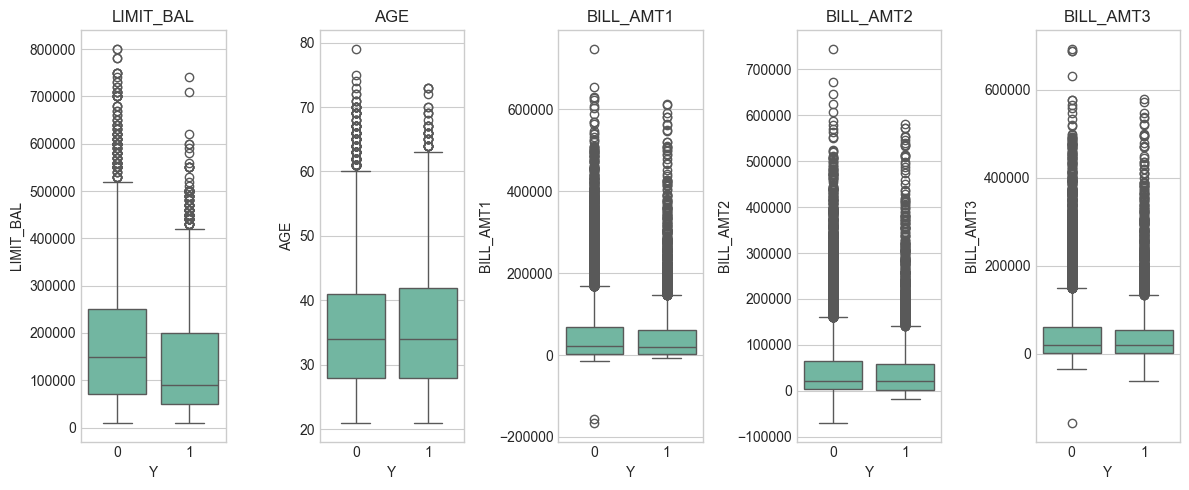

In [130]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF[num_vars].columns[:5].values)
for col_name in cols_loop :
	i = cols_loop.index(col_name)
	sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
	axs[i].set_ylabel(col_name)
	axs[i].set_title(col_name)

gs.tight_layout(plt.gcf())
plt.show()

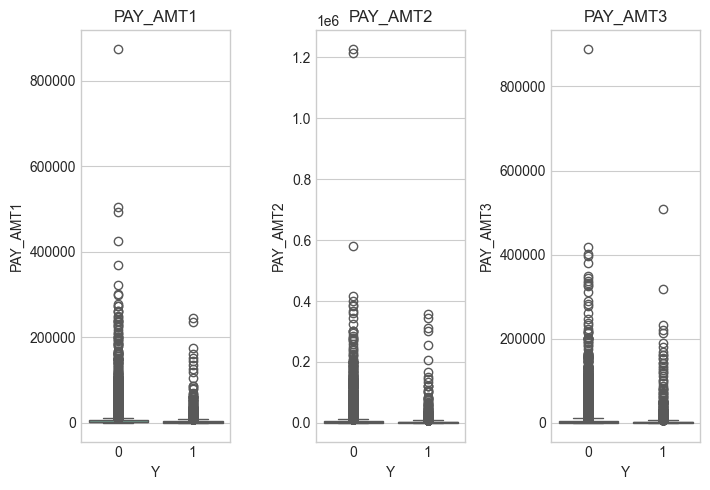

In [131]:
fig = plt.figure(figsize=(7.2, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])


axs = [ax1, ax2, ax3]

cols_loop = list(DF[num_vars].columns[5:].values)
for col_name in cols_loop :
	i = cols_loop.index(col_name)
	sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
	axs[i].set_ylabel(col_name)
	axs[i].set_title(col_name)

gs.tight_layout(plt.gcf())
plt.show()

#### Корреляционный анализ

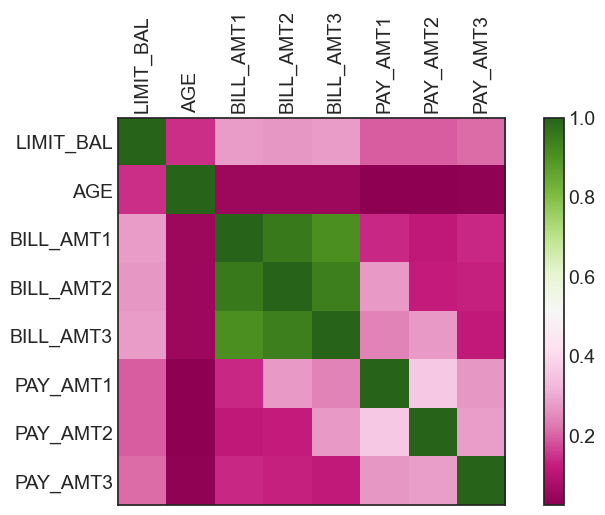

In [132]:
corr_mat = DF[num_vars].corr()
col_names = DF[num_vars].columns

mpl.style.use('seaborn-v0_8-white')

f = plt.figure(figsize=(10, 5))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')

tics_coords = np.arange(0, 	len(col_names))

plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

In [133]:
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))

df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']

t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))

df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
11,AGE,PAY_AMT2,0.024985,0.0
10,AGE,PAY_AMT1,0.028454,0.0
12,AGE,PAY_AMT3,0.029363,0.0
8,AGE,BILL_AMT2,0.052811,0.0
9,AGE,BILL_AMT3,0.053899,0.0
7,AGE,BILL_AMT1,0.054029,0.0
16,BILL_AMT1,PAY_AMT2,0.116312,0.0
24,BILL_AMT3,PAY_AMT3,0.116478,0.0
20,BILL_AMT2,PAY_AMT2,0.122303,0.0
21,BILL_AMT2,PAY_AMT3,0.129220,0.0


### Метод снижения размерности

In [134]:

sc = StandardScaler()
X_train_std = sc.fit_transform(DF[num_vars].values)

for i_col in range(X_train_std.shape[1]) :
	print('Столбец ', i_col, ': среднее = ', np.round(np.mean(X_train_std[:, i_col]), 2), ' Станд. отклонение = ', np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = 0.0 Станд. отклонение = 1.0
Столбец 1: среднее = -0.0 Станд. отклонение = 1.0
Столбец 2: среднее = -0.0 Станд. отклонение = 1.0
Столбец 3: среднее = 0.0 Станд. отклонение = 1.0
Столбец 4: среднее = -0.0 Станд. отклонение = 1.0
Столбец 5: среднее = -0.0 Станд. отклонение = 1.0
Столбец 6: среднее = 0.0 Станд. отклонение = 1.0
Столбец 7: среднее = 0.0 Станд. отклонение = 1.0


#### Регрессия на главные компоненты (PCR)

In [135]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_std)

frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n', np.around(frac_var_expl, 3), '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.401 0.184 0.13  0.099 0.091 0.081 0.009 0.003] 
Общая сумма долей: 1.0


In [136]:
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7
0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
1,0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
2,-0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0.0
3,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0
4,0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0
5,0.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0
6,0.0,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0
7,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,1.0


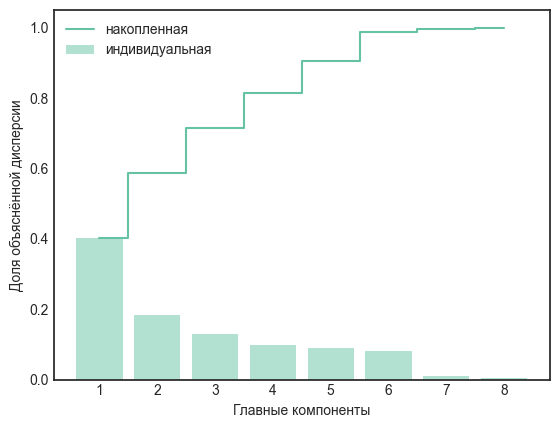

In [137]:
plt.bar(range(1, 9), pca.explained_variance_ratio_, alpha=0.5,
 align='center', label='индивидуальная')
plt.step(range(1, 9), np.cumsum(pca.explained_variance_ratio_),
 where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()


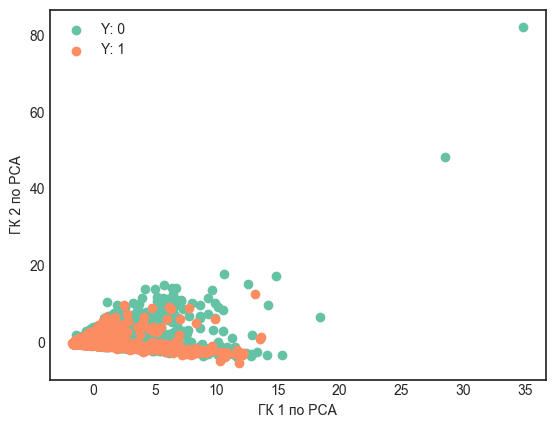

In [138]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()

In [139]:
logit = LogisticRegression()

kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)

score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10, scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам', '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.78


### Методы сжатия
#### Ридж-регрессия

In [140]:
Y_train = DF.Y.values
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
logit_ridge.fit(X_train_std, Y_train)
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3), '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))


Константы моделей для классов:
 [-1.376] 
Коэффициенты моделей для классов:
 [[-0.38   0.083 -0.738  0.484  0.442 -0.515 -0.358 -0.064]]


In [141]:
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)


ridge_cv.C_


array([0.0001])

In [142]:
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам', '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.779


C:\Users\lyaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\lyaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\lyaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was de

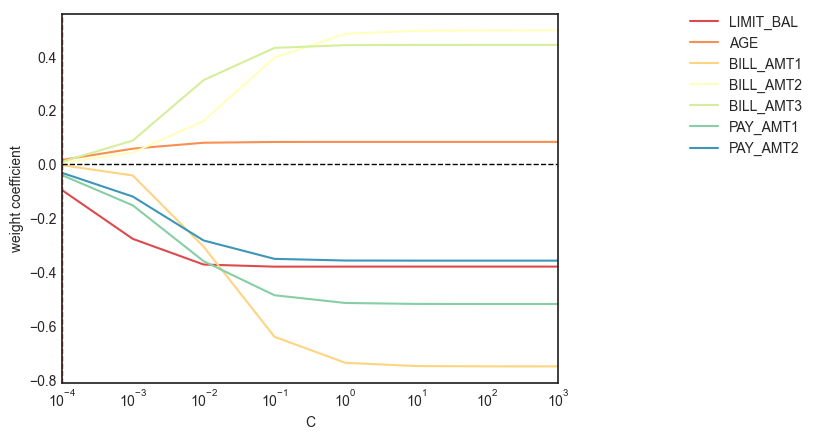

In [143]:
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF[num_vars].columns)

### Прогноз на отложенные наблюдения по лучшей модели

In [144]:
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PC2,0.779
1,logit_ridge,0.779


In [146]:

X_pred_std = sc.fit_transform(DF_predict[num_vars].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)

print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      3503
           1       0.00      0.00      0.00       997

    accuracy                           0.78      4500
   macro avg       0.39      0.50      0.44      4500
weighted avg       0.61      0.78      0.68      4500



C:\Users\lyaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lyaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lyaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

Точность прогноза составляет 78%